# Μέρος Α – CNN πάνω στο MNIST

**Σκοπός:**
- Κατεβάζει το MNIST και προβάλλει 1 εικόνα/κλάση
- Υλοποιεί SGD-training (mini-batches) της αρχιτεκτονικής LeNet-5 της Εικόνας 1
- Παρακολουθεί loss - accuracy ανά epoch και τα γράφει σε plots
- Υπολογίζει & εμφανίζει Confusion Matrix στο test set

## 1. Import Libraries και Αναπαραγωγιμότητα

In [28]:
# -*- coding: utf-8 -*-
"""
Μέρος Α – CNN πάνω στο MNIST
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
•  Κατεβάζει το MNIST και προβάλλει 1 εικόνα/κλάση
•  Υλοποιεί SGD-training (mini-batches) της αρχιτεκτονικής LeNet-5 της Εικόνας 1
•  Παρακολουθεί loss - accuracy ανά epoch και τα γράφει σε plots
•  Υπολογίζει & εμφανίζει Confusion Matrix στο test set
"""

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random, os, time
from matplotlib.gridspec import GridSpec

# 1.  Αναπαραγωγιμότητα
torch.manual_seed(0); np.random.seed(0); random.seed(0)

## 2. Φόρτωση Δεδομένων MNIST και Οπτικοποίηση

In [29]:
# 2.  Δεδομένα MNIST (28 × 28 grayscale)
transform = transforms.Compose([transforms.ToTensor()])
data_path = os.path.expanduser("~/mnist_data")

train_set = datasets.MNIST(data_path, train=True , download=True, transform=transform)
test_set  = datasets.MNIST(data_path, train=False, download=True, transform=transform)

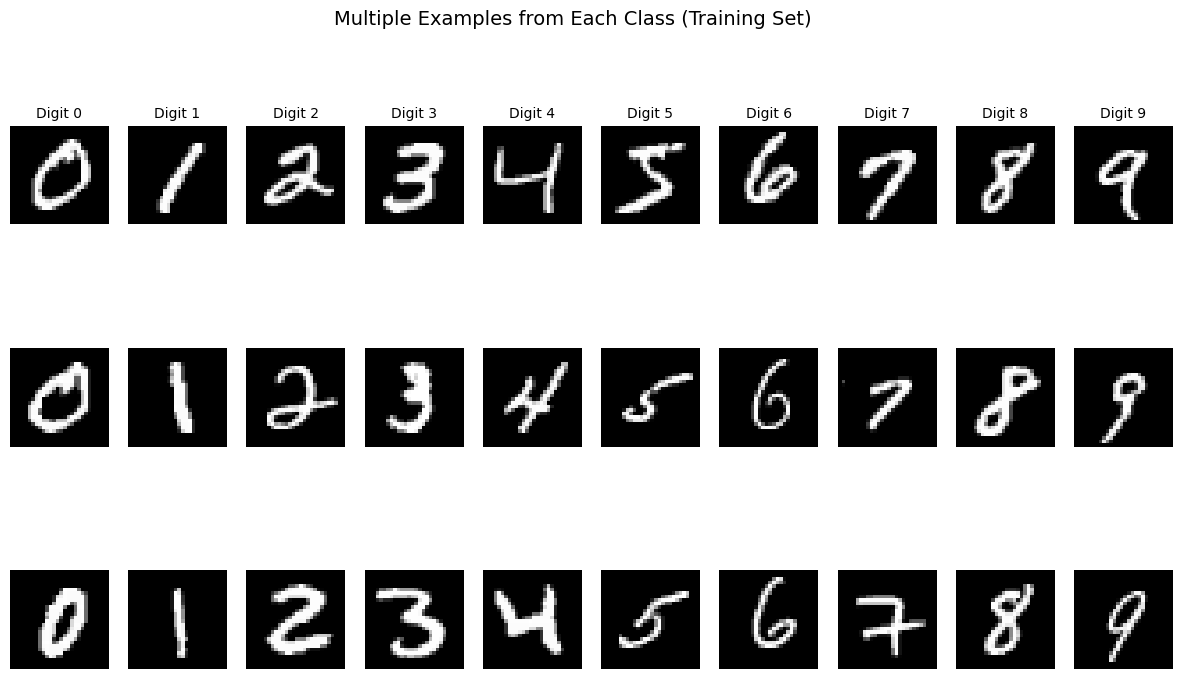

In [30]:
#  Enhanced visualization of samples from each class
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(3, 10, figure=fig, hspace=0.3, wspace=0.2)

# Show 3 examples per digit
for digit in range(10):
    examples = []
    for img, lbl in train_set:
        if lbl == digit:
            examples.append(img.squeeze().numpy())
        if len(examples) == 3:
            break
    
    for i, example in enumerate(examples):
        ax = fig.add_subplot(gs[i, digit])
        ax.imshow(example, cmap="gray")
        if i == 0:
            ax.set_title(f"Digit {digit}", fontsize=10)
        ax.axis("off")

fig.suptitle("Multiple Examples from Each Class (Training Set)", fontsize=14)
plt.show()

## 3. Hyper-Parameters και Data Loaders

In [31]:
# 3.  Hyper-Params & Loader
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size  = 64
epochs      = 10            
lr          = 0.01
momentum    = 0.9

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True , num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set , batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

## 4. Αρχιτεκτονική LeNet-5

In [32]:
# 4.  Αρχιτεκτονική – LeNet-5 (εικόνα 1)
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1 ,  6, kernel_size=3, stride=1, padding=0)   # 28→26
        self.pool1 = nn.AvgPool2d(2,2)                                        # 26→13
        self.conv2 = nn.Conv2d(6 , 16, kernel_size=3, stride=1, padding=0)    # 13→11
        self.pool2 = nn.AvgPool2d(2,2)                                        # 11→5
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84 , 10)
        self.relu  = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)          # flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)                # (logits)

## 5. Οπτικοποίηση Αρχιτεκτονικής

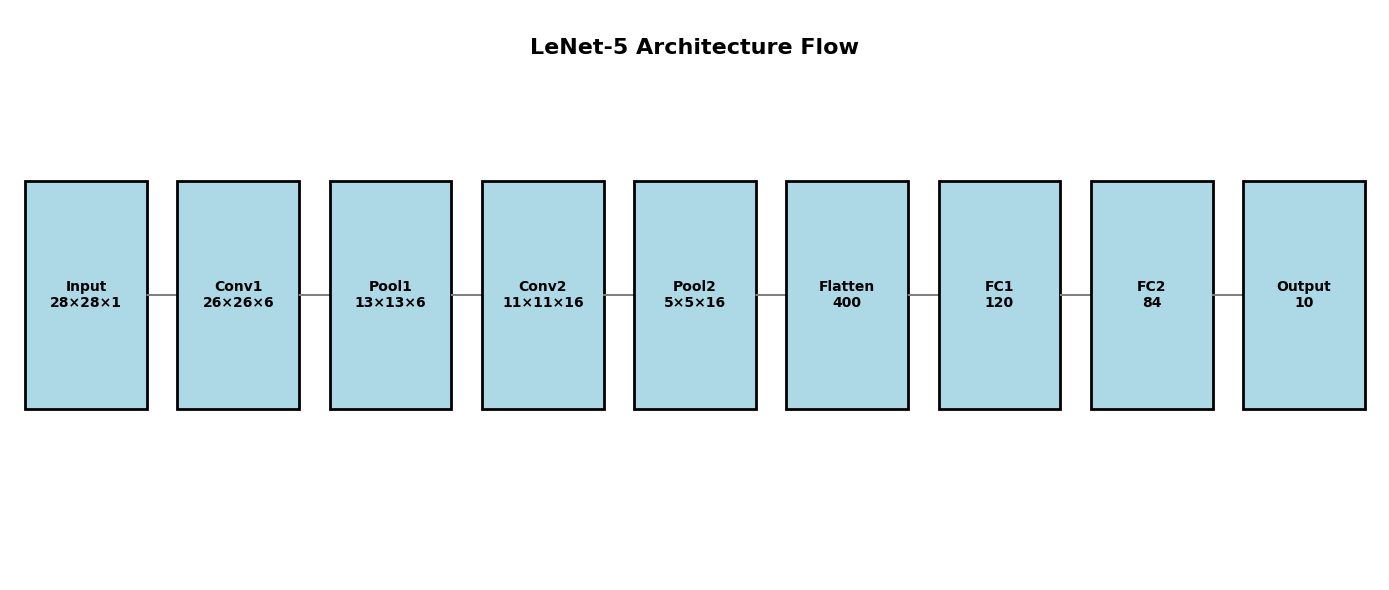

In [33]:
# Visualize model architecture
def visualize_architecture():
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.text(0.5, 0.95, 'LeNet-5 Architecture Flow', ha='center', va='top', 
            fontsize=16, weight='bold', transform=ax.transAxes)
    
    # Layer information
    layers = [
        ("Input\n28×28×1", 0.05),
        ("Conv1\n26×26×6", 0.15),
        ("Pool1\n13×13×6", 0.25),
        ("Conv2\n11×11×16", 0.35),
        ("Pool2\n5×5×16", 0.45),
        ("Flatten\n400", 0.55),
        ("FC1\n120", 0.65),
        ("FC2\n84", 0.75),
        ("Output\n10", 0.85)
    ]
    
    # Draw boxes and arrows
    for i, (layer, x) in enumerate(layers):
        rect = plt.Rectangle((x-0.04, 0.3), 0.08, 0.4, 
                           fill=True, facecolor='lightblue', 
                           edgecolor='black', linewidth=2)
        ax.add_patch(rect)
        ax.text(x, 0.5, layer, ha='center', va='center', fontsize=10, weight='bold')
        
        if i < len(layers) - 1:
            ax.arrow(x+0.04, 0.5, 0.06, 0, head_width=0.03, 
                    head_length=0.01, fc='gray', ec='gray')
    
    ax.set_xlim(0, 0.9)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_architecture()

## 6. Αρχικοποίηση Μοντέλου και Optimizer

In [34]:
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Device: {device}\n")


Model Summary:
Total parameters: 60,074
Trainable parameters: 60,074
Device: cuda



## 7. Training Loop με Real-time Monitoring

Epoch: 1, Batch: 0/938, Loss: 2.3072
Epoch: 1, Batch: 100/938, Loss: 2.2906
Epoch: 1, Batch: 200/938, Loss: 1.1147
Epoch: 1, Batch: 300/938, Loss: 0.4464
Epoch: 1, Batch: 400/938, Loss: 0.2481
Epoch: 1, Batch: 500/938, Loss: 0.2713
Epoch: 1, Batch: 600/938, Loss: 0.2629
Epoch: 1, Batch: 700/938, Loss: 0.2712
Epoch: 1, Batch: 800/938, Loss: 0.4872
Epoch: 1, Batch: 900/938, Loss: 0.1581
Epoch  1/10 | Train Loss: 0.7370 | Test Loss: 0.1996 | Test Accuracy: 93.63%


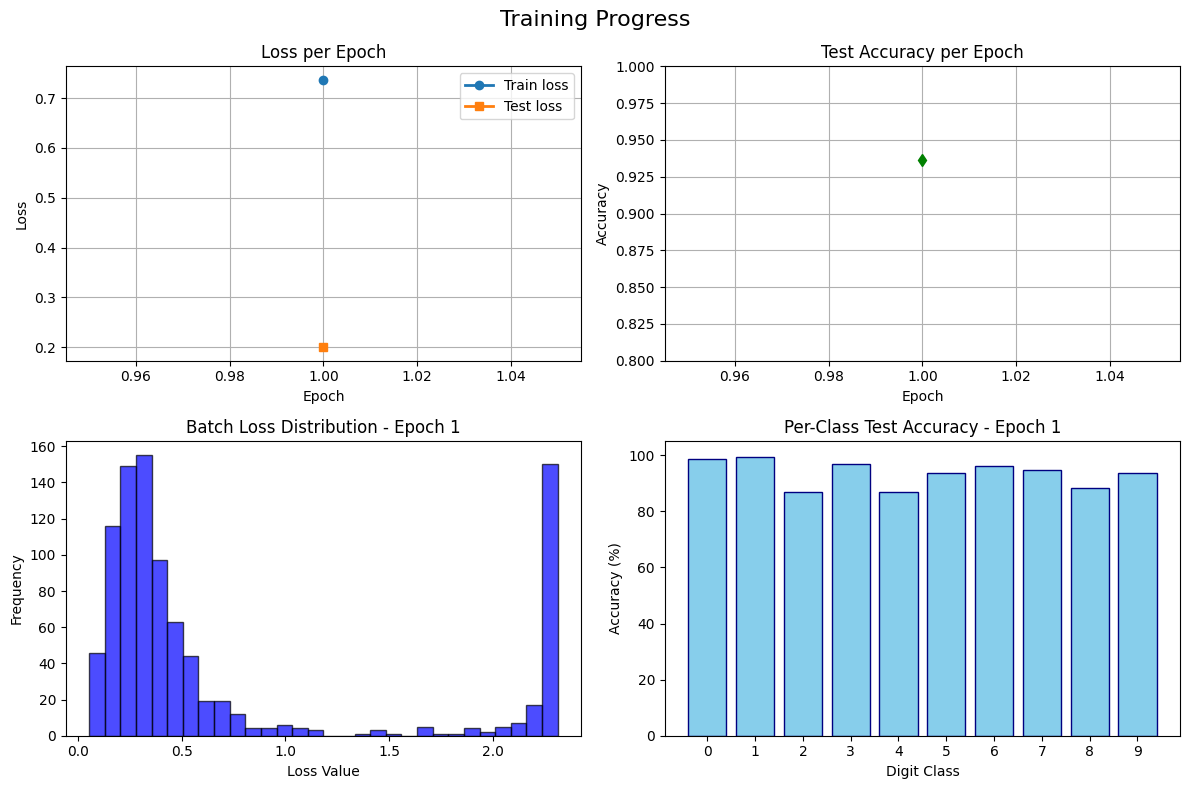

Epoch: 2, Batch: 0/938, Loss: 0.2053
Epoch: 2, Batch: 100/938, Loss: 0.2206
Epoch: 2, Batch: 100/938, Loss: 0.2206
Epoch: 2, Batch: 200/938, Loss: 0.1241
Epoch: 2, Batch: 200/938, Loss: 0.1241
Epoch: 2, Batch: 300/938, Loss: 0.1570
Epoch: 2, Batch: 300/938, Loss: 0.1570
Epoch: 2, Batch: 400/938, Loss: 0.1071
Epoch: 2, Batch: 400/938, Loss: 0.1071
Epoch: 2, Batch: 500/938, Loss: 0.2069
Epoch: 2, Batch: 500/938, Loss: 0.2069
Epoch: 2, Batch: 600/938, Loss: 0.2060
Epoch: 2, Batch: 600/938, Loss: 0.2060
Epoch: 2, Batch: 700/938, Loss: 0.0517
Epoch: 2, Batch: 700/938, Loss: 0.0517
Epoch: 2, Batch: 800/938, Loss: 0.1937
Epoch: 2, Batch: 800/938, Loss: 0.1937
Epoch: 2, Batch: 900/938, Loss: 0.1364
Epoch: 2, Batch: 900/938, Loss: 0.1364
Epoch  2/10 | Train Loss: 0.1532 | Test Loss: 0.1049 | Test Accuracy: 96.54%
Epoch  2/10 | Train Loss: 0.1532 | Test Loss: 0.1049 | Test Accuracy: 96.54%


<Figure size 640x480 with 0 Axes>

Epoch: 3, Batch: 0/938, Loss: 0.0795
Epoch: 3, Batch: 100/938, Loss: 0.1522
Epoch: 3, Batch: 100/938, Loss: 0.1522
Epoch: 3, Batch: 200/938, Loss: 0.0738
Epoch: 3, Batch: 200/938, Loss: 0.0738
Epoch: 3, Batch: 300/938, Loss: 0.0575
Epoch: 3, Batch: 300/938, Loss: 0.0575
Epoch: 3, Batch: 400/938, Loss: 0.0143
Epoch: 3, Batch: 400/938, Loss: 0.0143
Epoch: 3, Batch: 500/938, Loss: 0.0350
Epoch: 3, Batch: 500/938, Loss: 0.0350
Epoch: 3, Batch: 600/938, Loss: 0.0843
Epoch: 3, Batch: 600/938, Loss: 0.0843
Epoch: 3, Batch: 700/938, Loss: 0.0715
Epoch: 3, Batch: 700/938, Loss: 0.0715
Epoch: 3, Batch: 800/938, Loss: 0.0476
Epoch: 3, Batch: 800/938, Loss: 0.0476
Epoch: 3, Batch: 900/938, Loss: 0.0146
Epoch: 3, Batch: 900/938, Loss: 0.0146
Epoch  3/10 | Train Loss: 0.0982 | Test Loss: 0.0811 | Test Accuracy: 97.24%
Epoch  3/10 | Train Loss: 0.0982 | Test Loss: 0.0811 | Test Accuracy: 97.24%


<Figure size 640x480 with 0 Axes>

Epoch: 4, Batch: 0/938, Loss: 0.1723
Epoch: 4, Batch: 100/938, Loss: 0.0252
Epoch: 4, Batch: 100/938, Loss: 0.0252
Epoch: 4, Batch: 200/938, Loss: 0.0712
Epoch: 4, Batch: 200/938, Loss: 0.0712
Epoch: 4, Batch: 300/938, Loss: 0.0048
Epoch: 4, Batch: 300/938, Loss: 0.0048
Epoch: 4, Batch: 400/938, Loss: 0.0262
Epoch: 4, Batch: 400/938, Loss: 0.0262
Epoch: 4, Batch: 500/938, Loss: 0.1692
Epoch: 4, Batch: 500/938, Loss: 0.1692
Epoch: 4, Batch: 600/938, Loss: 0.0413
Epoch: 4, Batch: 600/938, Loss: 0.0413
Epoch: 4, Batch: 700/938, Loss: 0.2109
Epoch: 4, Batch: 700/938, Loss: 0.2109
Epoch: 4, Batch: 800/938, Loss: 0.1488
Epoch: 4, Batch: 800/938, Loss: 0.1488
Epoch: 4, Batch: 900/938, Loss: 0.0641
Epoch: 4, Batch: 900/938, Loss: 0.0641
Epoch  4/10 | Train Loss: 0.0767 | Test Loss: 0.0813 | Test Accuracy: 97.49%
Epoch  4/10 | Train Loss: 0.0767 | Test Loss: 0.0813 | Test Accuracy: 97.49%


<Figure size 640x480 with 0 Axes>

Epoch: 5, Batch: 0/938, Loss: 0.0546
Epoch: 5, Batch: 100/938, Loss: 0.0172
Epoch: 5, Batch: 100/938, Loss: 0.0172
Epoch: 5, Batch: 200/938, Loss: 0.1142
Epoch: 5, Batch: 200/938, Loss: 0.1142
Epoch: 5, Batch: 300/938, Loss: 0.0584
Epoch: 5, Batch: 300/938, Loss: 0.0584
Epoch: 5, Batch: 400/938, Loss: 0.0804
Epoch: 5, Batch: 400/938, Loss: 0.0804
Epoch: 5, Batch: 500/938, Loss: 0.1902
Epoch: 5, Batch: 500/938, Loss: 0.1902
Epoch: 5, Batch: 600/938, Loss: 0.0288
Epoch: 5, Batch: 600/938, Loss: 0.0288
Epoch: 5, Batch: 700/938, Loss: 0.0111
Epoch: 5, Batch: 700/938, Loss: 0.0111
Epoch: 5, Batch: 800/938, Loss: 0.0692
Epoch: 5, Batch: 800/938, Loss: 0.0692
Epoch: 5, Batch: 900/938, Loss: 0.0347
Epoch: 5, Batch: 900/938, Loss: 0.0347
Epoch  5/10 | Train Loss: 0.0632 | Test Loss: 0.0719 | Test Accuracy: 97.75%
Epoch  5/10 | Train Loss: 0.0632 | Test Loss: 0.0719 | Test Accuracy: 97.75%


<Figure size 640x480 with 0 Axes>

Epoch: 6, Batch: 0/938, Loss: 0.0562
Epoch: 6, Batch: 100/938, Loss: 0.0527
Epoch: 6, Batch: 100/938, Loss: 0.0527
Epoch: 6, Batch: 200/938, Loss: 0.0664
Epoch: 6, Batch: 200/938, Loss: 0.0664
Epoch: 6, Batch: 300/938, Loss: 0.0061
Epoch: 6, Batch: 300/938, Loss: 0.0061
Epoch: 6, Batch: 400/938, Loss: 0.0770
Epoch: 6, Batch: 400/938, Loss: 0.0770
Epoch: 6, Batch: 500/938, Loss: 0.0999
Epoch: 6, Batch: 500/938, Loss: 0.0999
Epoch: 6, Batch: 600/938, Loss: 0.0642
Epoch: 6, Batch: 600/938, Loss: 0.0642
Epoch: 6, Batch: 700/938, Loss: 0.0778
Epoch: 6, Batch: 700/938, Loss: 0.0778
Epoch: 6, Batch: 800/938, Loss: 0.0575
Epoch: 6, Batch: 800/938, Loss: 0.0575
Epoch: 6, Batch: 900/938, Loss: 0.0146
Epoch: 6, Batch: 900/938, Loss: 0.0146
Epoch  6/10 | Train Loss: 0.0542 | Test Loss: 0.0586 | Test Accuracy: 98.23%
Epoch  6/10 | Train Loss: 0.0542 | Test Loss: 0.0586 | Test Accuracy: 98.23%


<Figure size 640x480 with 0 Axes>

Epoch: 7, Batch: 0/938, Loss: 0.0040
Epoch: 7, Batch: 100/938, Loss: 0.0141
Epoch: 7, Batch: 100/938, Loss: 0.0141
Epoch: 7, Batch: 200/938, Loss: 0.0052
Epoch: 7, Batch: 200/938, Loss: 0.0052
Epoch: 7, Batch: 300/938, Loss: 0.0350
Epoch: 7, Batch: 300/938, Loss: 0.0350
Epoch: 7, Batch: 400/938, Loss: 0.0714
Epoch: 7, Batch: 400/938, Loss: 0.0714
Epoch: 7, Batch: 500/938, Loss: 0.0092
Epoch: 7, Batch: 500/938, Loss: 0.0092
Epoch: 7, Batch: 600/938, Loss: 0.0983
Epoch: 7, Batch: 600/938, Loss: 0.0983
Epoch: 7, Batch: 700/938, Loss: 0.0858
Epoch: 7, Batch: 700/938, Loss: 0.0858
Epoch: 7, Batch: 800/938, Loss: 0.0443
Epoch: 7, Batch: 800/938, Loss: 0.0443
Epoch: 7, Batch: 900/938, Loss: 0.0064
Epoch: 7, Batch: 900/938, Loss: 0.0064
Epoch  7/10 | Train Loss: 0.0458 | Test Loss: 0.0613 | Test Accuracy: 98.18%
Epoch  7/10 | Train Loss: 0.0458 | Test Loss: 0.0613 | Test Accuracy: 98.18%


<Figure size 640x480 with 0 Axes>

Epoch: 8, Batch: 0/938, Loss: 0.0105
Epoch: 8, Batch: 100/938, Loss: 0.0529
Epoch: 8, Batch: 100/938, Loss: 0.0529
Epoch: 8, Batch: 200/938, Loss: 0.1228
Epoch: 8, Batch: 200/938, Loss: 0.1228
Epoch: 8, Batch: 300/938, Loss: 0.0273
Epoch: 8, Batch: 300/938, Loss: 0.0273
Epoch: 8, Batch: 400/938, Loss: 0.0144
Epoch: 8, Batch: 400/938, Loss: 0.0144
Epoch: 8, Batch: 500/938, Loss: 0.0544
Epoch: 8, Batch: 500/938, Loss: 0.0544
Epoch: 8, Batch: 600/938, Loss: 0.0140
Epoch: 8, Batch: 600/938, Loss: 0.0140
Epoch: 8, Batch: 700/938, Loss: 0.0396
Epoch: 8, Batch: 700/938, Loss: 0.0396
Epoch: 8, Batch: 800/938, Loss: 0.0060
Epoch: 8, Batch: 800/938, Loss: 0.0060
Epoch: 8, Batch: 900/938, Loss: 0.0055
Epoch: 8, Batch: 900/938, Loss: 0.0055
Epoch  8/10 | Train Loss: 0.0407 | Test Loss: 0.0464 | Test Accuracy: 98.54%
Epoch  8/10 | Train Loss: 0.0407 | Test Loss: 0.0464 | Test Accuracy: 98.54%


<Figure size 640x480 with 0 Axes>

Epoch: 9, Batch: 0/938, Loss: 0.0089
Epoch: 9, Batch: 100/938, Loss: 0.0100
Epoch: 9, Batch: 100/938, Loss: 0.0100
Epoch: 9, Batch: 200/938, Loss: 0.0096
Epoch: 9, Batch: 200/938, Loss: 0.0096
Epoch: 9, Batch: 300/938, Loss: 0.0264
Epoch: 9, Batch: 300/938, Loss: 0.0264
Epoch: 9, Batch: 400/938, Loss: 0.0127
Epoch: 9, Batch: 400/938, Loss: 0.0127
Epoch: 9, Batch: 500/938, Loss: 0.0239
Epoch: 9, Batch: 500/938, Loss: 0.0239
Epoch: 9, Batch: 600/938, Loss: 0.0019
Epoch: 9, Batch: 600/938, Loss: 0.0019
Epoch: 9, Batch: 700/938, Loss: 0.0677
Epoch: 9, Batch: 700/938, Loss: 0.0677
Epoch: 9, Batch: 800/938, Loss: 0.0093
Epoch: 9, Batch: 800/938, Loss: 0.0093
Epoch: 9, Batch: 900/938, Loss: 0.0251
Epoch: 9, Batch: 900/938, Loss: 0.0251
Epoch  9/10 | Train Loss: 0.0338 | Test Loss: 0.0462 | Test Accuracy: 98.53%
Epoch  9/10 | Train Loss: 0.0338 | Test Loss: 0.0462 | Test Accuracy: 98.53%


<Figure size 640x480 with 0 Axes>

Epoch: 10, Batch: 0/938, Loss: 0.0745
Epoch: 10, Batch: 100/938, Loss: 0.1246
Epoch: 10, Batch: 100/938, Loss: 0.1246
Epoch: 10, Batch: 200/938, Loss: 0.0107
Epoch: 10, Batch: 200/938, Loss: 0.0107
Epoch: 10, Batch: 300/938, Loss: 0.0637
Epoch: 10, Batch: 300/938, Loss: 0.0637
Epoch: 10, Batch: 400/938, Loss: 0.0722
Epoch: 10, Batch: 400/938, Loss: 0.0722
Epoch: 10, Batch: 500/938, Loss: 0.0641
Epoch: 10, Batch: 500/938, Loss: 0.0641
Epoch: 10, Batch: 600/938, Loss: 0.0040
Epoch: 10, Batch: 600/938, Loss: 0.0040
Epoch: 10, Batch: 700/938, Loss: 0.0775
Epoch: 10, Batch: 700/938, Loss: 0.0775
Epoch: 10, Batch: 800/938, Loss: 0.0115
Epoch: 10, Batch: 800/938, Loss: 0.0115
Epoch: 10, Batch: 900/938, Loss: 0.0105
Epoch: 10, Batch: 900/938, Loss: 0.0105
Epoch 10/10 | Train Loss: 0.0323 | Test Loss: 0.0433 | Test Accuracy: 98.73%
Epoch 10/10 | Train Loss: 0.0323 | Test Loss: 0.0433 | Test Accuracy: 98.73%


<Figure size 640x480 with 0 Axes>


 Συνολικός χρόνος: 158.4s



In [35]:
# 5.  Enhanced Training with batch tracking
train_loss_hist, test_loss_hist, test_acc_hist = [], [], []
batch_loss_hist = []  # Track loss per batch
start_time = time.time()

# Create figure for real-time plotting
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Training Progress', fontsize=16)

for epoch in range(1, epochs+1):
    # --- Train ---
    model.train()
    running_loss = 0.0
    batch_losses = []
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        running_loss += batch_loss * images.size(0)
        
        # Show progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}/{len(train_loader)}, Loss: {batch_loss:.4f}')

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_loss_hist.append(epoch_train_loss)
    batch_loss_hist.extend(batch_losses)

    # --- Test ---
    model.eval(); test_loss = 0; correct = 0; all_preds, all_labels = [], []
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()*images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            
            # Per-class accuracy
            c = (preds == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_acc  = correct / len(test_loader.dataset)
    test_loss_hist.append(epoch_test_loss)
    test_acc_hist .append(epoch_test_acc)

    print(f"Epoch {epoch:2d}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f} | "
          f"Test Accuracy: {epoch_test_acc*100:.2f}%")
    
    # Update plots during training
    axes[0, 0].clear()
    axes[0, 0].plot(range(1, epoch+1), train_loss_hist, 'o-', label="Train loss", linewidth=2)
    axes[0, 0].plot(range(1, epoch+1), test_loss_hist, 's-', label="Test loss", linewidth=2)
    axes[0, 0].set_xlabel("Epoch"); axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Loss per Epoch"); axes[0, 0].legend(); axes[0, 0].grid(True)
    
    axes[0, 1].clear()
    axes[0, 1].plot(range(1, epoch+1), test_acc_hist, 'd-', color='green', linewidth=2)
    axes[0, 1].set_xlabel("Epoch"); axes[0, 1].set_ylabel("Accuracy")
    axes[0, 1].set_title("Test Accuracy per Epoch"); axes[0, 1].grid(True)
    axes[0, 1].set_ylim(0.8, 1.0)
    
    # Batch loss distribution for current epoch
    axes[1, 0].clear()
    axes[1, 0].hist(batch_losses, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[1, 0].set_xlabel("Loss Value"); axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].set_title(f"Batch Loss Distribution - Epoch {epoch}")
    
    # Per-class accuracy
    axes[1, 1].clear()
    class_accuracies = [100.0 * class_correct[i]/class_total[i] for i in range(10)]
    axes[1, 1].bar(range(10), class_accuracies, color='skyblue', edgecolor='navy')
    axes[1, 1].set_xlabel("Digit Class"); axes[1, 1].set_ylabel("Accuracy (%)")
    axes[1, 1].set_title(f"Per-Class Test Accuracy - Epoch {epoch}")
    axes[1, 1].set_ylim(0, 105)
    axes[1, 1].set_xticks(range(10))
    
    plt.tight_layout()
    plt.pause(0.1)

plt.ioff()
print(f"\n Συνολικός χρόνος: {(time.time()-start_time):.1f}s")

## 8. Comprehensive Training Analysis Plots

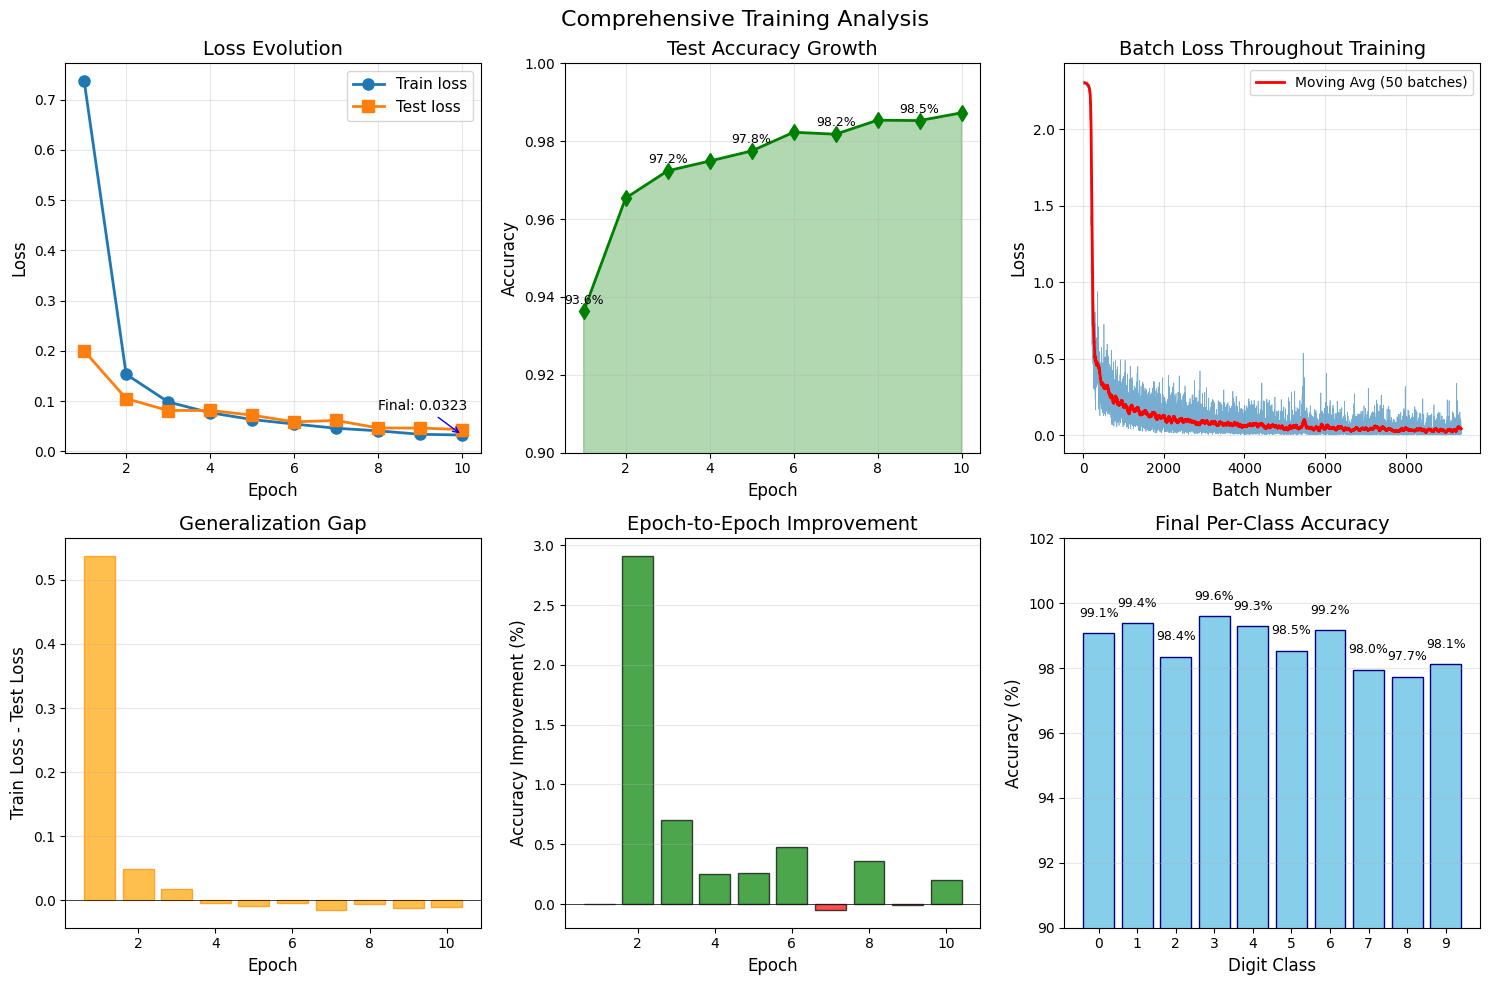

In [36]:
# 6. Final comprehensive plots
plt.figure(figsize=(15, 10))

# Loss curves with annotations
plt.subplot(2, 3, 1)
plt.plot(range(1, epochs+1), train_loss_hist, 'o-', label="Train loss", linewidth=2, markersize=8)
plt.plot(range(1, epochs+1), test_loss_hist, 's-', label="Test loss", linewidth=2, markersize=8)
plt.xlabel("Epoch", fontsize=12); plt.ylabel("Loss", fontsize=12)
plt.title("Loss Evolution", fontsize=14); plt.legend(fontsize=11); plt.grid(True, alpha=0.3)
# Annotate final values
plt.annotate(f'Final: {train_loss_hist[-1]:.4f}', 
            xy=(epochs, train_loss_hist[-1]), xytext=(epochs-2, train_loss_hist[-1]+0.05),
            arrowprops=dict(arrowstyle='->', color='blue'), fontsize=10)

# Accuracy with trend
plt.subplot(2, 3, 2)
plt.plot(range(1, epochs+1), test_acc_hist, 'd-', color='green', linewidth=2, markersize=8)
plt.fill_between(range(1, epochs+1), test_acc_hist, alpha=0.3, color='green')
plt.xlabel("Epoch", fontsize=12); plt.ylabel("Accuracy", fontsize=12)
plt.title("Test Accuracy Growth", fontsize=14); plt.grid(True, alpha=0.3)
plt.ylim(0.9, 1.0)
# Add percentage labels
for i, acc in enumerate(test_acc_hist[::2]):
    plt.text(2*i+1, acc+0.002, f'{acc*100:.1f}%', ha='center', fontsize=9)

# Learning rate effect visualization
plt.subplot(2, 3, 3)
batch_range = range(len(batch_loss_hist))
plt.plot(batch_range, batch_loss_hist, alpha=0.6, linewidth=0.5)
# Add moving average
window = 50
moving_avg = np.convolve(batch_loss_hist, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(batch_loss_hist)), moving_avg, 'r-', linewidth=2, label=f'Moving Avg ({window} batches)')
plt.xlabel("Batch Number", fontsize=12); plt.ylabel("Loss", fontsize=12)
plt.title("Batch Loss Throughout Training", fontsize=14)
plt.legend(); plt.grid(True, alpha=0.3)

# Loss difference (generalization gap)
plt.subplot(2, 3, 4)
loss_diff = [train - test for train, test in zip(train_loss_hist, test_loss_hist)]
plt.bar(range(1, epochs+1), loss_diff, color='orange', alpha=0.7, edgecolor='darkorange')
plt.xlabel("Epoch", fontsize=12); plt.ylabel("Train Loss - Test Loss", fontsize=12)
plt.title("Generalization Gap", fontsize=14); plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Improvement rate
plt.subplot(2, 3, 5)
if len(test_acc_hist) > 1:
    improvement = [0] + [(test_acc_hist[i] - test_acc_hist[i-1])*100 for i in range(1, len(test_acc_hist))]
    colors = ['green' if x >= 0 else 'red' for x in improvement]
    plt.bar(range(1, epochs+1), improvement, color=colors, alpha=0.7, edgecolor='black')
    plt.xlabel("Epoch", fontsize=12); plt.ylabel("Accuracy Improvement (%)", fontsize=12)
    plt.title("Epoch-to-Epoch Improvement", fontsize=14); plt.grid(True, alpha=0.3, axis='y')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Final per-class performance
plt.subplot(2, 3, 6)
plt.bar(range(10), class_accuracies, color='skyblue', edgecolor='navy')
for i, acc in enumerate(class_accuracies):
    plt.text(i, acc + 0.5, f'{acc:.1f}%', ha='center', fontsize=9)
plt.xlabel("Digit Class", fontsize=12); plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Final Per-Class Accuracy", fontsize=14)
plt.ylim(90, 102); plt.xticks(range(10))
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle("Comprehensive Training Analysis", fontsize=16)
plt.tight_layout()
plt.show()

## 9. Confusion Matrix Analysis

In [37]:
# 7. Enhanced Confusion Matrix with additional metrics
def compute_confusion_matrix(true_labels, pred_labels, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(true_labels, pred_labels):
        cm[true][pred] += 1
    return cm

# Υπολογισμός confusion matrix
cm = compute_confusion_matrix(all_labels, all_preds)

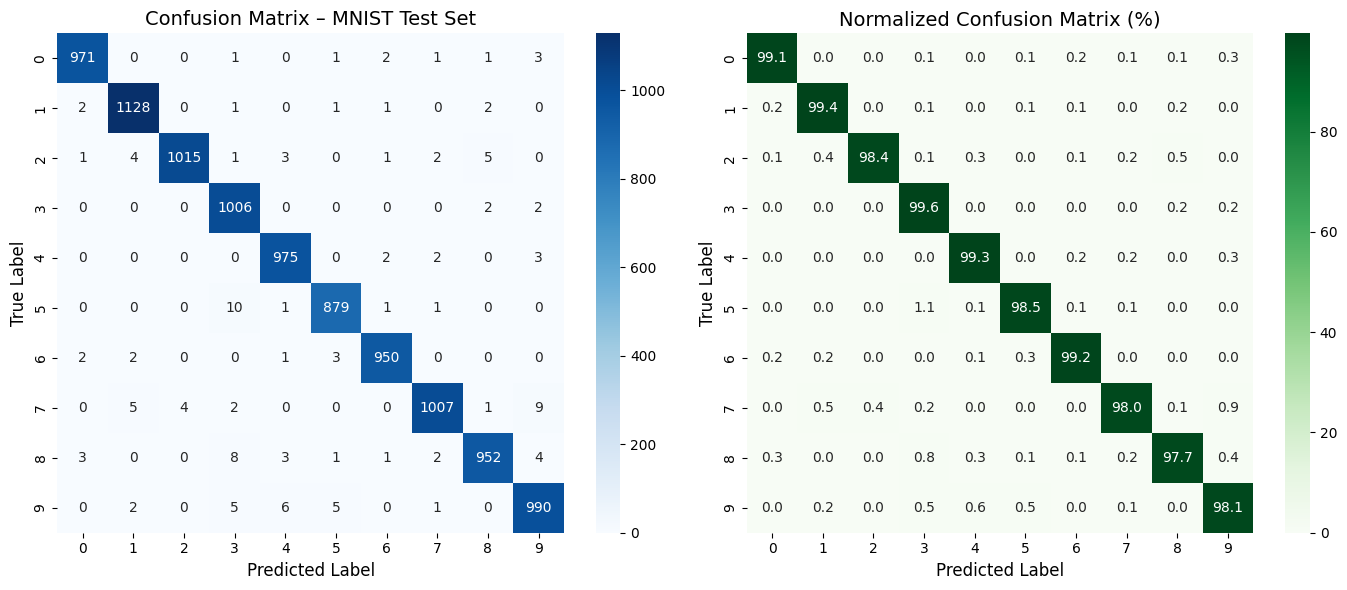

In [38]:
# Create enhanced confusion matrix visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Standard confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=list(range(10)), yticklabels=list(range(10)), ax=ax1)
ax1.set_xlabel("Predicted Label", fontsize=12)
ax1.set_ylabel("True Label", fontsize=12)
ax1.set_title("Confusion Matrix – MNIST Test Set", fontsize=14)

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap="Greens", cbar=True,
            xticklabels=list(range(10)), yticklabels=list(range(10)), ax=ax2)
ax2.set_xlabel("Predicted Label", fontsize=12)
ax2.set_ylabel("True Label", fontsize=12)
ax2.set_title("Normalized Confusion Matrix (%)", fontsize=14)

plt.tight_layout()
plt.show()

## 10. Error Analysis και Performance Summary

In [39]:
# Most confused pairs analysis
confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nTop 10 Most Confused Digit Pairs:")
print("True → Predicted | Count")
print("-" * 25)
for true, pred, count in confusion_pairs[:10]:
    print(f"  {true}  →    {pred}     |  {count}")


Top 10 Most Confused Digit Pairs:
True → Predicted | Count
-------------------------
  5  →    3     |  10
  7  →    9     |  9
  8  →    3     |  8
  9  →    4     |  6
  2  →    8     |  5
  7  →    1     |  5
  9  →    3     |  5
  9  →    5     |  5
  2  →    1     |  4
  7  →    2     |  4


In [40]:
# Model performance summary
print("\nFinal Model Performance Summary:")
print("=" * 40)
print(f"Final Training Loss: {train_loss_hist[-1]:.4f}")
print(f"Final Test Loss: {test_loss_hist[-1]:.4f}")
print(f"Final Test Accuracy: {test_acc_hist[-1]*100:.2f}%")
print(f"Best Test Accuracy: {max(test_acc_hist)*100:.2f}% (Epoch {test_acc_hist.index(max(test_acc_hist))+1})")
print("=" * 40)


Final Model Performance Summary:
Final Training Loss: 0.0323
Final Test Loss: 0.0433
Final Test Accuracy: 98.73%
Best Test Accuracy: 98.73% (Epoch 10)
